Parameter Fitting

In [1]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from scipy.stats import linregress

Total Reps:  2
Total FOVs:  6
Total cells:  132
Time points:  21
degradation rate: -0.01903638143008867


C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_20696\2821389046.py:37: RuntimeWarning: Mean of empty slice
  dataMean = np.nanmean(dataTensor, axis=0)
d:\Anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_20696\2821389046.py:66: RuntimeWarning: divide by zero encountered in log
  log_data_fit = np.log(data_fit)


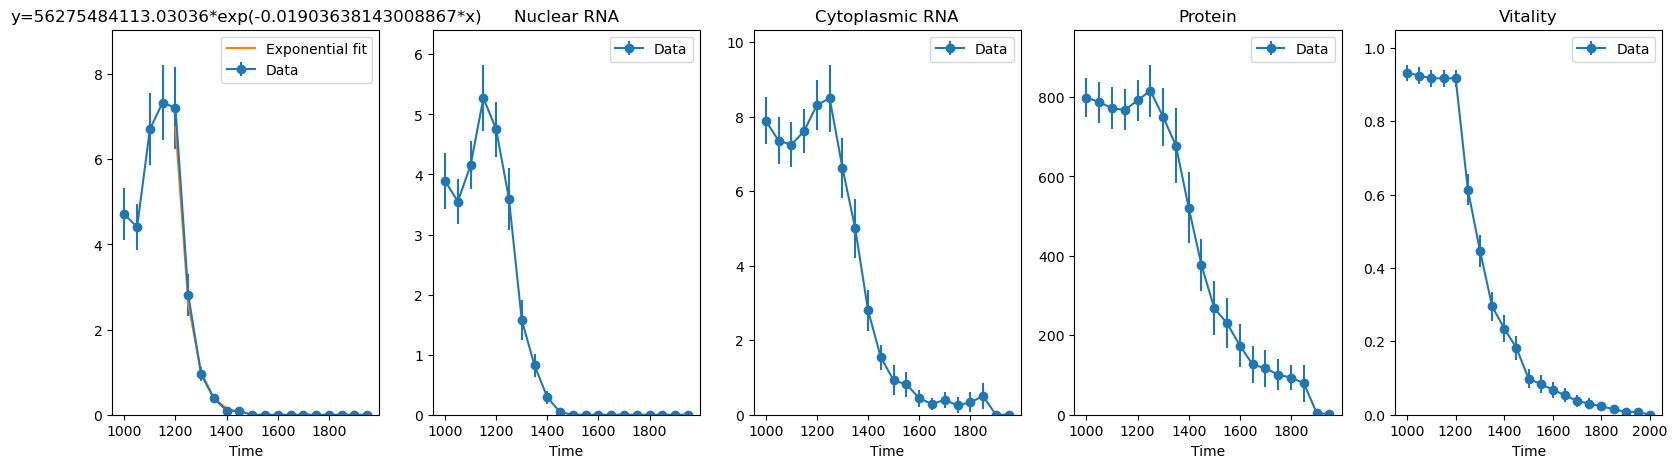

In [2]:
# Load data from CSV in file.
dataRaw = pd.read_csv('../TrueData/Drug6_10000nM_DesignResults.csv')

# Parse data to create tensor containing all data in format:
# [Cell, Time, NascentRNA, NuclearRNA, CytoplasmicRNA, Protein, Vitality]
k = 0

Reps = np.unique(dataRaw['Rep_Num'])
FOVs = np.unique(dataRaw['FOV_Num'])
Times = np.unique(dataRaw['Time'])
Cells = np.unique(dataRaw['Cell_id'])

print('Total Reps: ', len(Reps))
print('Total FOVs: ', len(FOVs))
print('Total cells: ', len(Cells))
print('Time points: ', len(Times))

dataTensor = np.zeros((len(Cells), len(Times), 5))

for iCell in range(len(Cells)):
    for iTime in range(len(Times)):
        if dataRaw['is_cell_vital'][k]==1:
            dataTensor[iCell, iTime, 0] = dataRaw['num_rna_nascent'][k]
            dataTensor[iCell, iTime, 1] = dataRaw['num_rna_nuc'][k]
            dataTensor[iCell, iTime, 2] = dataRaw['num_rna_cyto'][k]
            dataTensor[iCell, iTime, 3] = dataRaw['Cyto_Intensity_1'][k]
            dataTensor[iCell, iTime, 4] = 1
        else:
            dataTensor[iCell, iTime, 0] = np.nan
            dataTensor[iCell, iTime, 1] = np.nan
            dataTensor[iCell, iTime, 2] = np.nan
            dataTensor[iCell, iTime, 3] = np.nan
            dataTensor[iCell, iTime, 4] = 0
        k += 1

# Calculate mean and SEM of each data type at each time point. Ignore NaN values.
dataMean = np.nanmean(dataTensor, axis=0)
dataStd = np.nanstd(dataTensor, axis=0) / np.sqrt(np.sum(~np.isnan(dataTensor), axis=0))

featureNames = ['Nascent RNA', 'Nuclear RNA', 'Cytoplasmic RNA', 'Protein', 'Vitality']

# Plot data
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].errorbar(Times, dataMean[:, i], yerr=dataStd[:, i], fmt='-o', label='Data')
    
    ax[i].set_title(featureNames[i])
    ax[i].set_xlabel('Time')
    ax[i].set_ylim([0, 1.1 * np.nanmax(dataMean[:, i] + dataStd[:, i])])
    ax[i].legend()

# Fit parameter

# Define exponential function
def expFunc(t, a, b):
    return a * np.exp(-b * t)

t_fit = Times[Times >= 1200]
data_fit = dataMean[:,0][Times >= 1200]
# check if there exits nan or inf in data_fit
mask = ~np.isnan(data_fit) & ~np.isinf(data_fit)

# exclude nan or inf
t_fit = t_fit[mask]
data_fit = data_fit[mask]
log_data_fit = np.log(data_fit)
mask_2 = ~np.isnan(data_fit) & ~np.isinf(log_data_fit)
t_fit = t_fit[mask_2]
log_data_fit = log_data_fit[mask_2]
data_fit = data_fit[mask_2]
slope, intercept, _, _, _ = linregress(t_fit, log_data_fit)
best_fit_line = np.exp(intercept) * np.exp(slope * t_fit)

# Calculate the exponential function parameters
a = np.exp(intercept)
b = slope
title = f'y={a}*exp({b}*x)'

ax[0].set_title(title)
ax[0].plot(t_fit, best_fit_line, label='Exponential fit')
ax[0].legend()
print('degradation rate:', b)

In [4]:
# get the mean of dataMean
# Load data from CSV in file.
dataRaw = pd.read_csv('../TrueData/NoDrug_DesignResults.csv')

# Parse data to create tensor containing all data in format:
# [Cell, Time, NascentRNA, NuclearRNA, CytoplasmicRNA, Protein, Vitality]
k = 0

Reps = np.unique(dataRaw['Rep_Num'])
FOVs = np.unique(dataRaw['FOV_Num'])
Times = np.unique(dataRaw['Time'])
Cells = np.unique(dataRaw['Cell_id'])

print('Total Reps: ', len(Reps))
print('Total FOVs: ', len(FOVs))
print('Total cells: ', len(Cells))
print('Time points: ', len(Times))

dataTensor = np.zeros((len(Cells), len(Times), 5))

for iCell in range(len(Cells)):
    for iTime in range(len(Times)):
        if dataRaw['is_cell_vital'][k]==1:
            dataTensor[iCell, iTime, 0] = dataRaw['num_rna_nascent'][k]
            dataTensor[iCell, iTime, 1] = dataRaw['num_rna_nuc'][k]
            dataTensor[iCell, iTime, 2] = dataRaw['num_rna_cyto'][k]
            dataTensor[iCell, iTime, 3] = dataRaw['Cyto_Intensity_1'][k]
            dataTensor[iCell, iTime, 4] = 1
        else:
            dataTensor[iCell, iTime, 0] = np.nan
            dataTensor[iCell, iTime, 1] = np.nan
            dataTensor[iCell, iTime, 2] = np.nan
            dataTensor[iCell, iTime, 3] = np.nan
            dataTensor[iCell, iTime, 4] = 0
        k += 1

# Calculate mean and SEM of each data type at each time point. Ignore NaN values.
dataMean = np.nanmean(dataTensor, axis=0)
x = np.nanmean(dataMean, axis=0)
# get the parameter of ODE model from steady state
# x0 means the steady state of Nascent RNA, 
# x1 means the steady state of Nuclear RNA, 
# x2 means the steady state of Cytoplasmic RNA, 
# x3 means the steady state of Protein
# dx0/dt=k1-k2*x0,
# dx1/dt=k2*x0-(k3+k7)*x1, 
# dx2/dt=k3*x1-k6*x2, 
# dx3/dt=k4*x2-k5*x3, 
k2=0.019
k6=0.009
k5=0.01
k1=x[0]*k2
k4=k5*x[3]/x[2]
k3=k6*x[2]/x[1]
k7=(k2*x[0]-k3*x[1])/x[1]
parameters=[k1,k2,k3,k4,k5,k6,k7]
parameters

Total Reps:  2
Total FOVs:  6
Total cells:  141
Time points:  21


[0.12087724596552575,
 0.019,
 0.01624417283926601,
 0.960962416548879,
 0.01,
 0.009,
 0.010914466496796857]